# Library

In [1]:
import numpy as np
from numpy import array
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import string, os, glob, pickle, sys
from time import time
import json
from PIL import Image
import collections
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers
import tensorflow.keras.preprocessing as tfkp
import re
from nltk.translate.bleu_score import sentence_bleu

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, GRU, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.efficientnet_v2 import EfficientNetV2M 
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.efficientnet_v2 import preprocess_input 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Download data

In [3]:
image_folder = '/train2017_n'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2017.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2017.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

19336871936/19336861798 [==============================] - 291s 0us/step


# Config

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# PHUS
'''
CONFIG
'''
train_imgs_path = '/content/train2017/'
val_imgs_path = train_imgs_path
test_imgs_path = train_imgs_path
train_annatations_path = "/content/drive/MyDrive/AI/data/UIT-ViIC/uitviic_captions_train2017.json"
val_annatations_path = "/content/drive/MyDrive/AI/data/UIT-ViIC/uitviic_captions_val2017.json"
test_annatations_path = "/content/drive/MyDrive/AI/data/UIT-ViIC/uitviic_captions_test2017.json"

# Load & Preprocess data

## Caption proprocessing

Remove puntuation

In [6]:
translator = str.maketrans('', '', string.punctuation)

Python script for Vietnamese tone normalization

In [7]:
dict_map = {
    "òa": "oà",
    "Òa": "Oà",
    "ÒA": "OÀ",
    "óa": "oá",
    "Óa": "Oá",
    "ÓA": "OÁ",
    "ỏa": "oả",
    "Ỏa": "Oả",
    "ỎA": "OẢ",
    "õa": "oã",
    "Õa": "Oã",
    "ÕA": "OÃ",
    "ọa": "oạ",
    "Ọa": "Oạ",
    "ỌA": "OẠ",
    "òe": "oè",
    "Òe": "Oè",
    "ÒE": "OÈ",
    "óe": "oé",
    "Óe": "Oé",
    "ÓE": "OÉ",
    "ỏe": "oẻ",
    "Ỏe": "Oẻ",
    "ỎE": "OẺ",
    "õe": "oẽ",
    "Õe": "Oẽ",
    "ÕE": "OẼ",
    "ọe": "oẹ",
    "Ọe": "Oẹ",
    "ỌE": "OẸ",
    "ùy": "uỳ",
    "Ùy": "Uỳ",
    "ÙY": "UỲ",
    "úy": "uý",
    "Úy": "Uý",
    "ÚY": "UÝ",
    "ủy": "uỷ",
    "Ủy": "Uỷ",
    "ỦY": "UỶ",
    "ũy": "uỹ",
    "Ũy": "Uỹ",
    "ŨY": "UỸ",
    "ụy": "uỵ",
    "Ụy": "Uỵ",
    "ỤY": "UỴ",
    }

def replace_all(text, dict_map):
    for i, j in dict_map.items():
        text = text.replace(i, j)
    return text

replace_all('ngụy', dict_map)

'nguỵ'

Vietnamese tokenizer by Underthesea

In [8]:
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.3 MB/s 
     |████████████████████████████████| 235 kB 53.3 MB/s 
     |████████████████████████████████| 581 kB 66.5 MB/s 
     |████████████████████████████████| 965 kB 59.1 MB/s 


In [9]:
from underthesea import word_tokenize
sentence = 'Chàng trai 9X Quảng Trị khởi nghiệp từ nấm sò'

print(word_tokenize(sentence))
print(word_tokenize(sentence, format="text"))

['Chàng', 'trai', '9X', 'Quảng Trị', 'khởi nghiệp', 'từ', 'nấm', 'sò']
Chàng trai 9X Quảng_Trị khởi_nghiệp từ nấm sò


Normalize unicode

In [10]:
import regex as re

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"


def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic


dicchar = loaddicchar()


def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

Combine All of them

In [11]:
def clean_description(desc):
    # Prepare translator for removing punctuation
    translator = str.maketrans('', '', string.punctuation)

    
    # Remove punctuations from each token
    desc = desc.translate(translator)

    # Tokenize
    desc = word_tokenize(desc)

    # Convert to lowercase
    desc = [word.lower() for word in desc]

    # Remove hanging words
    desc = [word for word in desc if (len(word) > 1)]

    # Normalize unicode
    desc = [convert_unicode(word) for word in desc]

    #--------- IF NOT USE PhoW2V, plz comment this----------
    # Normalize for PhoW2V
    desc = [replace_all(word, dict_map) for word in desc]

    # Store as string
    f_desc = ' '.join(desc) 

    return f_desc 

text = clean_description('Vailon. Toi khong hòa hợp được với hắn')

print(text)

vailon toi khong hoà hợp được với hắn


## Load img and desc

In [12]:
def load_json_file(filepath):
  with open(filepath, 'r') as f:
    content = json.load(f)
    return content

In [13]:
def get_img_path_to_annatation(doc, path):
  '''
    doc: a json file contains info about img and its 5 annatation
    path: path to img folder
  '''

  temp_dict = collections.defaultdict(list)
  for val in doc['annotations']:
    caption = f"<start> {clean_description(val['caption'])} <end>"    
    image_path = path + '%012d.jpg' % (val['image_id'])
    temp_dict[image_path].append(caption)
  return temp_dict

In [14]:
def get_path_from_dict(input_dict):
  return list(input_dict.keys())

In [15]:
def get_per_img_per_annotation_from_dict(input_dict):
  img_lst_path = list(input_dict.keys())

  annotations = []
  img_paths = []

  for img_path in img_lst_path:
    annotation_lst = input_dict[img_path]
    annotations.extend(annotation_lst)
    img_paths.extend([img_path] * len(annotation_lst))
  print(img_paths)
  return img_paths, annotations

In [16]:
# train_data_dict, val_data_dict, test_data_dict là các dict.
# key: link ảnh, value: list gồm 5 mô tả của ảnh đã tiền xử lý

train_data_dict = get_img_path_to_annatation(load_json_file(train_annatations_path), train_imgs_path)
val_data_dict = get_img_path_to_annatation(load_json_file(val_annatations_path), val_imgs_path)
test_data_dict = get_img_path_to_annatation(load_json_file(test_annatations_path), test_imgs_path)

In [17]:
# train_img_data chứa path dẫn tới ảnh.
# train_annotations_data: chứa annotations của ảnh.
# Ảnh, annotations tương ứng cùng idx.

train_img_data, train_annotations_data = get_per_img_per_annotation_from_dict(train_data_dict)
val_img_data, val_annotations_data = get_per_img_per_annotation_from_dict(val_data_dict)
test_img_data, test_annotations_data = get_per_img_per_annotation_from_dict(test_data_dict)

['/content/train2017/000000157656.jpg', '/content/train2017/000000157656.jpg', '/content/train2017/000000157656.jpg', '/content/train2017/000000157656.jpg', '/content/train2017/000000157656.jpg', '/content/train2017/000000049860.jpg', '/content/train2017/000000049860.jpg', '/content/train2017/000000049860.jpg', '/content/train2017/000000049860.jpg', '/content/train2017/000000049860.jpg', '/content/train2017/000000053702.jpg', '/content/train2017/000000053702.jpg', '/content/train2017/000000053702.jpg', '/content/train2017/000000053702.jpg', '/content/train2017/000000053702.jpg', '/content/train2017/000000487198.jpg', '/content/train2017/000000487198.jpg', '/content/train2017/000000487198.jpg', '/content/train2017/000000487198.jpg', '/content/train2017/000000487198.jpg', '/content/train2017/000000487204.jpg', '/content/train2017/000000487204.jpg', '/content/train2017/000000487204.jpg', '/content/train2017/000000487204.jpg', '/content/train2017/000000487204.jpg', '/content/train2017/0000

Make sure we use the same data on all sets

In [18]:
train_data_dict = {k: train_data_dict[k] for k in train_img_data}
val_data_dict = {k: val_data_dict[k] for k in val_data_dict}
test_data_dict = {k: test_data_dict[k] for k in test_data_dict}

# Process the data

## Create vocab

In [19]:
# Convert the loaded descriptions into a vocabulary of words
def to_vocabulary(data_dict):
    #  Create a vocabulary of all the uniqimage captions (corpus) in the datue words present across all the 8000*5 
    # (i.e. 40000) a set
    vocabulary = set()
    for image_name in data_dict.keys():
        [vocabulary.update(caption.split()) for caption in data_dict[image_name]]
    return vocabulary

vocabulary = to_vocabulary(train_data_dict)

print(f'Original Vocabulary size: {len(vocabulary)}')
print(f'Vocabulary: {vocabulary}')

Original Vocabulary size: 1170
Vocabulary: {'nhặt', 'xoạc', 'vopwjt', 'kẽm', 'nó', 'tai', 'câu', 'tthi', 'trần', 'cậu', 'gò', 'bẳt', 'nhực', 'quàn', 'dính', 'khung', 'ngã', 'gập', 'diễn', 'đưa', 'bút', 'sô', 'điển', 'rượt', 'sàng', 'một', 'khu', 'thị', 'mã', 'phiên', 'đứa', 'cánh', 'ba', 'bươc', 'giường', 'chấp', 'dàn', 'hòng', 'bự', '45', 'phát', 'ô', 'đáu', 'trên', 'váy', 'em', 'vui', 'thử', 'sinh', 'lồng', 'cốc', 'chèo', 'tách', 'thú', 'nến', 'lơ', 'xusc', 'chuyền', 'ném', 'giáo', 'súng', 'quyến', 'vải', 'hữu', 'rũ', 'bữa', 'vệ', 'thước', 'diều', 'gấu', 'sỡ', 'tiếp', 'tời', 'tennsi', 'sáu', 'mộ', 'le', 'tả', 'đuổi', 'túi', 'cự', 'phòng', 'lưỡi', 'nằm', 'quang', 'vì', 'đua', 'đá', 'xách', 'tivi', 'núi', 'bay', 'photoshop', 'nội', 'hành', 'triển', 'bình', 'còn', 'võng', 'cho', 'ngém', 'bột', 'màu', 'coke', 'đồi', 'tennisq', 'cúi', 'áo', 'vào', 'lấy', 'bong', 'nhìn', 'quanh', 'thầy', 'nhật', 'dành', 'xe', 'là', 'hào', 'trưng', 'bãi', 'dĩa', 'thang', 'ngôi', 'nhắm', 'bạc', 'máy', 'vè', 

In [20]:
# Create a list of all the training captions
train_captions = []

for image_name, captions in train_data_dict.items():
    for caption in captions:
        train_captions.append(caption)

# Consider only words which occur at least 3 times in the corpus
word_count_threshold = 3
word_counts = {}
n_captions = 0

for caption in train_captions:
    n_captions += 1
    for word in caption.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocabulary = [word for word in word_counts if (word_counts[word] >= word_count_threshold)]
vocab_size = len(vocabulary)
print(f'Processed Vocabulary size: {len(vocabulary)}')
print(f'Vocabulary: {vocabulary}')

Processed Vocabulary size: 633
Vocabulary: ['<start>', 'người', 'đàn', 'ông', 'đang', 'đánh', 'tennis', 'ngoài', 'sân', '<end>', 'một', 'vận', 'động', 'viên', 'vung', 'vợt', 'bóng', 'cầu', 'thủ', 'đỡ', 'đứng', 'biên', 'cầm', 'sẵn', 'sàng', 'nam', 'trong', 'tư', 'thế', 'chuẩn', 'bị', 'màn', 'hình', 'máy', 'tính', 'trắng', 'đặt', 'trên', 'chiếc', 'bàn', 'gỗ', 'cái', 'và', 'có', 'quả', 'nảy', 'màu', 'vàng', 'dưới', 'đất', 'ảnh', 'bên', 'cạnh', 'chơi', 'ném', 'dĩa', 'số', 'những', 'luyện', 'tập', 'cùng', 'nhau', 'phụ', 'nữ', 'thi', 'đấu', 'về', 'phía', 'áo', 'trước', 'nhiều', 'quan', 'sát', 'đông', 'đảo', 'khán', 'giả', 'đen', 'nhóm', 'chụp', 'vườn', 'hai', 'tạo', 'dáng', 'bức', 'của', 'với', 'vươn', 'chạy', 'tới', 'cố', 'gắng', 'thấp', 'cây', 'đám', 'vào', 'tay', 'nghiệp', 'sắp', 'bé', 'gái', 'đá', 'cỏ', 'cô', 'xem', 'bắt', 'nhựa', 'đứa', 'trẻ', 'nhỏ', 'cho', 'dù', 'con', 'chó', 'cam', 'lên', 'cổ', 'cậu', 'các', 'tranh', 'giành', 'hàng', 'rào', 'mặc', 'đồ', 'tụ', 'giao', 'trận', 'bay', 'đ

## Preprocess image using EfficientNetV2M

In [21]:
# # Get the InceptionV3 model trained on imagenet data
model = EfficientNetV2M(weights='imagenet')
# # Remove the last layer (output softmax layer) from the inception v3
# model = tfk.models.Model(model.input, model.layers[-2].output)
model = tfk.models.Model(model.input, model.layers[-2].output)

219340800/219330792 [==============================] - 4s 0us/step


In [22]:
for layer in model.layers:
  print(layer.output_shape)

[(None, 480, 480, 3)]
(None, 480, 480, 3)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 240, 240, 24)
(None, 120, 120, 96)
(None, 120, 120, 96)
(None, 120, 120, 96)
(None, 120, 120, 48)
(None, 120, 120, 48)
(None, 120, 120, 192)
(None, 120, 120, 192)
(None, 120, 120, 192)
(None, 120, 120, 48)
(None, 120, 120, 48)
(None, 120, 120, 48)
(None, 120, 120, 192)
(None, 120, 120, 192)
(None, 120, 120, 192)
(None, 120, 120, 48)
(None, 120, 120, 48)
(None, 120, 120, 48)
(None, 120, 120, 192)
(None, 120, 120, 192)
(None, 120, 120, 192)
(None, 120, 120, 48)
(None, 120, 120, 48)
(None, 120, 120, 48)
(None, 120, 120, 192)
(None, 120, 120, 192)
(None, 120, 120, 192)
(None, 120, 120, 48)
(None, 120, 120, 48)
(None, 120, 120, 48)
(None, 60, 60, 192)
(N

In [23]:
# we pass every image to this model to get the corresponding 2048 length feature vector
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = tfkp.image.load_img(image_path, target_size=(480, 480))

    # Convert PIL image to numpy array of 3-dimensions
    x = tfk.utils.img_to_array(img)
    
    # Add one more dimension
    x = np.expand_dims(x, axis=0)

    # preprocess images using preprocess_input() from inception module
    x = preprocess_input(x)

    return x

# Function to encode a given image into a vector of size (2048, )
def encode(image, model):
    image = preprocess(image)
    # Get the encoding vector for the image
    feature_vector = model.predict(image)
    # Reshape from (1, 1280) to (1280,)
    feature_vector = np.reshape(feature_vector, feature_vector.shape[1])
    # print(feature_vector.shape)
    return feature_vector

In [24]:
# Below path contains all the images
images = '/content/train2017/'

Features of Images are extracted! Plz skip these codes and load from Drive

In [25]:
# # Encode all the train images
# encoding_train = {}
# for train_img_full_path_i in tqdm(train_img_data):
#     current_img = train_img_full_path_i[len(images):]
#     encoding_train[current_img] = encode(train_img_full_path_i, model)

In [26]:
# # # Encode all the test images
# encoding_test = {}
# for test_img_full_path_i in tqdm(test_img_data):
#     current_img = test_img_full_path_i[len(images):]
#     encoding_test[current_img] = encode(test_img_full_path_i, model)

In [27]:
# # # Encode all the val images
# encoding_val = {}
# for val_img_full_path_i in tqdm(val_img_data):
#     current_img = val_img_full_path_i[len(images):]
#     encoding_val[current_img] = encode(val_img_full_path_i, model)

Save encoding to pickle files

In [28]:
# # Save the bottleneck train features to disk
# path = '/content/drive/MyDrive/AI/AI projects/Image Captioning/models/encoded_train_images_efficientV2M.pkl'
# with open(path, 'wb') as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)

# # Save the bottleneck test features to disk
# path = '/content/drive/MyDrive/AI/AI projects/Image Captioning/models/encoded_test_images_efficientV2M.pkl'
# with open(path, 'wb') as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)

# # Save the bottleneck val features to disk
# path = '/content/drive/MyDrive/AI/AI projects/Image Captioning/models/encoded_val_images_effiecientV2M.pkl'
# with open(path, 'wb') as encoded_pickle:
#     pickle.dump(encoding_val, encoded_pickle)

In [29]:
path = '/content/drive/MyDrive/AI/AI projects/Image Captioning/models/encoded_train_images_efficientV2M.pkl'
train_features = pickle.load(open(path, 'rb'))
print(f'len(train_features): {len(train_features)}')

len(train_features): 2695


## Data preprocessing caption

In [30]:
word2idx = {}
idx2word = {}

idx = 1
for word in vocabulary:
    word2idx[word] = idx
    idx2word[idx] = word
    idx += 1

In [31]:
vocab_size = len(idx2word) + 1 # one for appended 0's
vocab_size

634

In [32]:
# The maximum length of a caption
# Convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = []
    for image_name in descriptions.keys():
        [all_desc.append(caption) for caption in descriptions[image_name]]
    return all_desc

# calculate the length of the description with the most words
def max_length_median(descriptions):
    lines = to_lines(descriptions)
    desc_lenths = np.array(list((len(caption.split()) for caption in lines)))
    return np.quantile(desc_lenths, 0.95)

# determine the maximum sequence length
max_length = max_length_median(train_data_dict)
print(f'Max Training Description Length: {max_length}')

Max Training Description Length: 18.0


## Data Preparation using Generator Function

In [33]:
# Data generator, intended to be used in a call to model.fit_generator()

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            key = key[len(images):]
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

#  Word Embedding

Download PhoW2V Syllable 300d

In [34]:
# from tqdm import tqdm
# import requests

# # file url
# url = 'https://public.vinai.io/word2vec_vi_syllables_300dims.zip' # PhoW2V
# # url = 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip' # GloVe
# # stream true is required
# response = requests.get(url, stream=True)
# # total file size
# t = int(response.headers.get('content-length', 0))
# block_size = 1024**2 #1 Mbit
# progress_bar = tqdm(total=t, unit='iB', unit_scale=True)
# with open('word2vec_vi_syllables_300dims.zip', 'wb') as file:
#     for data in response.iter_content(block_size):
#         progress_bar.update(len(data))
#         file.write(data)
# progress_bar.close()
# if ( t != 0 ) and ( progress_bar.n != t ) : print("ERROR downloading file!")

In [35]:
# !unzip /content/word2vec_vi_syllables_300dims.zip
# !unzip /content/glove.6B.zip

In [36]:
# word2vec = {}
# with open('/content/word2vec_vi_syllables_300dims.txt', encoding='utf-8') as f:
#     for line in f:
#         word, vec = line.split(' ', 1)
#         word2vec[word] = np.fromstring(vec, sep=' ')

# print(f"{len(word2vec)} words loaded!")

In [37]:
# embedding_dim = 300

# # Get 200-dim dense vector for each of the 10000 words in out vocabulary
# embedding_matrix = np.zeros((vocab_size, embedding_dim))

# for word, i in word2idx.items():
#     #if i < max_words:
#     embedding_vector = word2vec.get(word)
    
#     if embedding_vector is not None:
#         # Words not found in the embedding index will be all zeros
#         embedding_matrix[i-1] = embedding_vector

In [38]:
embedding_dim = 300

with open('/content/drive/MyDrive/AI/AI projects/Image Captioning/models/embedding_matrix.npy', 'rb') as f:
    embedding_matrix = np.load(f)

# Model Architecture

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

In [40]:
max_length = int(max_length)

inputs1 = Input(shape=(1280,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='Mish')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se21 = Bidirectional(LSTM(256, return_sequences = True))(se2)
se3 = GRU(256)(se21)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='Mish')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1 , inputs2], outputs=outputs)

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 18, 300)      190200      ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 dropout_1 (Dropout)            (None, 18, 300)      0           ['embedding[0][0]']              
                                                                                            

In [42]:
model.layers[1]

In [43]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

In [44]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [45]:
epochs = 20
number_pics_per_bath = 8
steps = len(train_data_dict)//number_pics_per_bath

In [46]:
# for i in range(epochs):
#     generator = data_generator(train_data_dict, train_features, word2idx, max_length, number_pics_per_bath)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save('/content/drive/MyDrive/AI/AI projects/Image Captioning/models/PhoW2V_EfficientNetV2M_BiLSTM/model_' + str(i) + '.h5')

# Testing

In [48]:
# model.load_weights('/content/drive/MyDrive/AI/AI projects/Image Captioning/models/PhoW2V_EfficientNetV2M_BiLSTM_19.h5')

In [49]:
images = '/content/train2017/'

In [50]:
with open("/content/drive/MyDrive/AI/AI projects/Image Captioning/models/encoded_test_images_efficientV2M.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [51]:
def greedySearch(photo):
    in_text = '<start>'
    for i in range(max_length):
        sequence = [word2idx[w] for w in in_text.split() if w in word2idx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += ' ' + word
        if word == '<end>':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [52]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            # e = encoding_test[image[len(images):]]
            e = encoding_test[image]
            preds = model.predict([np.array([e]), np.array(par_caps)])
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [53]:
# z = 0
# pic = list(encoding_test.keys())[z]
# image = encoding_test[pic].reshape((1,2048))
# x=plt.imread(images+pic)
# plt.imshow(x)
# plt.show()
# print("Greedy:",beam_search_predictions(pic))

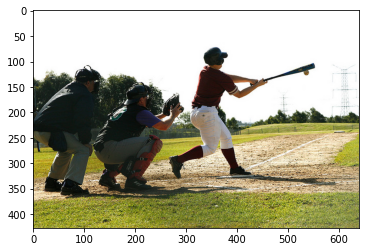

Greedy: đuổi đuổi đuổi đuổi đuổi đuổi đuổi đuổi đuổi đuổi đuổi đuổi đuổi đuổi đuổi đuổi đuổi


In [54]:
z= 199
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,1280))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

# Evaluation

In [55]:
!pip install pycocoevalcap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 104.3 MB 63 kB/s 


In [56]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

In [57]:
'''
  gts_dict: ground truth
  res_dict: references, predicted
'''

def score(gts_dict, res_dict):
    bleu_score = Bleu(n=4)
    bleu, _ = bleu_score.compute_score(gts=gts_dict, res=res_dict)

    rouge_scorer = Rouge()
    rouge, _ = rouge_scorer.compute_score(gts=gts_dict, res=res_dict)

    cider_scorer = Cider()
    cider, _ = cider_scorer.compute_score(gts=gts_dict, res=res_dict)

    return bleu, rouge, cider



def evaluation_beamSearch(model, descriptions, encoding_test, max_length):
    gts_dict, res_dict = {}, {}
    # step over the whole set
    for key, desc_list in tqdm(descriptions.items()):
        pic = key[len(images):]
        image = encoding_test[pic].reshape((1,2048))
        # generate description
        yhat = beam_search_predictions(pic)
        print(yhat)

        # Trimming <end> from yhat
        splited_yhat = yhat.split()
        y_hat_new = []
        for n in range(max_length):
                word = splited_yhat[n]
                if word != '<end>':
                    y_hat_new.append(word)
                else:
                    break
        yhat = ' '.join(y_hat_new)

        # Trimming <end>, <start> from desc_list
        new_desc_list = []
        for desc in desc_list:
          splited_desc = desc.split()
          desc = ' '.join(splited_desc[1:-1])
          new_desc_list.append(desc)
        desc_list = new_desc_list

        # store actual and predicted
        gts_dict[pic] = desc_list
        res_dict[pic] = [yhat]

    # calculate BLEU score
    b, r, c = score(gts_dict, res_dict)
    print('\n ********** BLEU-4 ********** \n', b)
    print('\n ********** ROUGH ********** \n', r)
    print('\n ********** CIDAr (NOT CIDAr-D) ********** \n', c)

    return gts_dict, res_dict

In [58]:
'''
  gts_dict: ground truth
  res_dict: references, predicted
'''

def score(gts_dict, res_dict):
    bleu_score = Bleu(n=4)
    bleu, _ = bleu_score.compute_score(gts=gts_dict, res=res_dict)

    rouge_scorer = Rouge()
    rouge, _ = rouge_scorer.compute_score(gts=gts_dict, res=res_dict)

    cider_scorer = Cider()
    cider, _ = cider_scorer.compute_score(gts=gts_dict, res=res_dict)

    return bleu, rouge, cider



def evaluation(model, descriptions, encoding_test, max_length):
    gts_dict, res_dict = {}, {}
    # step over the whole set
    for key, desc_list in tqdm(descriptions.items()):
        pic = key[len(images):]
        image = encoding_test[pic].reshape((1,1280))
        # generate description
        yhat = greedySearch(image)

        # Trimming <end> from yhat
        splited_yhat = yhat.split()
        y_hat_new = []
        for n in range(len(splited_yhat)):
                word = splited_yhat[n]
                if word != '<end>':
                    y_hat_new.append(word)
                else:
                    break
        yhat = ' '.join(y_hat_new)

        # Trimming <end>, <start> from desc_list
        new_desc_list = []
        for desc in desc_list:
          splited_desc = desc.split()
          desc = ' '.join(splited_desc[1:-1])
          new_desc_list.append(desc)
        desc_list = new_desc_list

        # store actual and predicted
        gts_dict[pic] = desc_list
        res_dict[pic] = [yhat]

    # calculate BLEU score
    b, r, c = score(gts_dict, res_dict)
    print('\n ********** BLEU-4 ********** \n', b)
    print('\n ********** ROUGH ********** \n', r)
    print('\n ********** CIDAr (NOT CIDAr-D) ********** \n', c)

    return gts_dict, res_dict

In [59]:
path = '/content/drive/MyDrive/AI/AI projects/Image Captioning/models/encoded_test_images_efficientV2M.pkl'
test_features = pickle.load(open(path, 'rb'))
print(f'len(train_features): {len(test_features)}')

len(train_features): 231


In [60]:
# model.load_weights('/content/drive/MyDrive/AI/AI projects/Image Captioning/models/PhoW2V_EfficientNetV2M_BiLSTM/model_13' + '.h5')

In [61]:
models_ = os.listdir('/content/drive/MyDrive/AI/AI projects/Image Captioning/models/PhoW2V_EfficientNetV2M_BiLSTM/')
for model_ in models_:
  print("------", model_, "------")
  model.load_weights('/content/drive/MyDrive/AI/AI projects/Image Captioning/models/PhoW2V_EfficientNetV2M_BiLSTM/' + model_)
  actual, predicted = evaluation(model, test_data_dict, test_features, max_length)

------ model_0.h5 ------


100%|██████████| 231/231 [03:27<00:00,  1.11it/s]


{'testlen': 2506, 'reflen': 2538, 'guess': [2506, 2275, 2044, 1813], 'correct': [1749, 1070, 701, 434]}
ratio: 0.987391646965726

 ********** BLEU-4 ********** 
 [0.6890695883653317, 0.5656657710362951, 0.4767277385501581, 0.4000270717137835]

 ********** ROUGH ********** 
 0.5855390050620987

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0279381368331464
------ model_1.h5 ------


100%|██████████| 231/231 [03:05<00:00,  1.25it/s]


{'testlen': 2469, 'reflen': 2500, 'guess': [2469, 2238, 2007, 1776], 'correct': [1681, 971, 622, 408]}
ratio: 0.987599999999605

 ********** BLEU-4 ********** 
 [0.6723474411832423, 0.5367227678212622, 0.44507178223923394, 0.37606561757373497]

 ********** ROUGH ********** 
 0.5675139460115859

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0480830684870932
------ model_2.h5 ------


100%|██████████| 231/231 [03:06<00:00,  1.24it/s]


{'testlen': 2522, 'reflen': 2528, 'guess': [2522, 2291, 2060, 1829], 'correct': [1659, 890, 531, 342]}
ratio: 0.9976265822780864

 ********** BLEU-4 ********** 
 [0.6562481457724155, 0.5043126896754967, 0.4029006420947715, 0.33234815040296006]

 ********** ROUGH ********** 
 0.5384429124416885

 ********** CIDAr (NOT CIDAr-D) ********** 
 0.8650303518866429
------ model_3.h5 ------


100%|██████████| 231/231 [03:09<00:00,  1.22it/s]


{'testlen': 2543, 'reflen': 2546, 'guess': [2543, 2312, 2081, 1850], 'correct': [1737, 977, 615, 405]}
ratio: 0.9988216810679502

 ********** BLEU-4 ********** 
 [0.6822461870564779, 0.5366211121478447, 0.43968542357846346, 0.36923196329578767]

 ********** ROUGH ********** 
 0.5618485561377127

 ********** CIDAr (NOT CIDAr-D) ********** 
 0.9766681117052539
------ model_4.h5 ------


100%|██████████| 231/231 [03:11<00:00,  1.21it/s]


{'testlen': 2539, 'reflen': 2542, 'guess': [2539, 2308, 2077, 1846], 'correct': [1708, 938, 575, 367]}
ratio: 0.9988198269075536

 ********** BLEU-4 ********** 
 [0.671911411749178, 0.5222554147209854, 0.4225012850859411, 0.34982539284564823]

 ********** ROUGH ********** 
 0.5534626719372254

 ********** CIDAr (NOT CIDAr-D) ********** 
 0.9132614648660672
------ model_5.h5 ------


100%|██████████| 231/231 [03:09<00:00,  1.22it/s]


{'testlen': 2542, 'reflen': 2550, 'guess': [2542, 2311, 2080, 1849], 'correct': [1722, 965, 604, 385]}
ratio: 0.9968627450976483

 ********** BLEU-4 ********** 
 [0.675290780457668, 0.5301828849072101, 0.4333306520779459, 0.36049879489433306]

 ********** ROUGH ********** 
 0.5593339404071692

 ********** CIDAr (NOT CIDAr-D) ********** 
 0.9573791512918515
------ model_6.h5 ------


100%|██████████| 231/231 [03:07<00:00,  1.23it/s]


{'testlen': 2541, 'reflen': 2547, 'guess': [2541, 2310, 2079, 1848], 'correct': [1725, 977, 620, 398]}
ratio: 0.9976442873965459

 ********** BLEU-4 ********** 
 [0.6772654882567175, 0.5345742315774309, 0.43971969430671154, 0.36763837866958315]

 ********** ROUGH ********** 
 0.5663807712883842

 ********** CIDAr (NOT CIDAr-D) ********** 
 0.9839540918369698
------ model_7.h5 ------


100%|██████████| 231/231 [03:11<00:00,  1.21it/s]


{'testlen': 2569, 'reflen': 2556, 'guess': [2569, 2338, 2107, 1876], 'correct': [1754, 1011, 647, 421]}
ratio: 1.0050860719870873

 ********** BLEU-4 ********** 
 [0.682755936161665, 0.5433580013648438, 0.4492319395339014, 0.377672432180466]

 ********** ROUGH ********** 
 0.5676213542689985

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0160057797598945
------ model_8.h5 ------


100%|██████████| 231/231 [03:09<00:00,  1.22it/s]


{'testlen': 2599, 'reflen': 2586, 'guess': [2599, 2368, 2137, 1906], 'correct': [1758, 1004, 633, 401]}
ratio: 1.0050270688317846

 ********** BLEU-4 ********** 
 [0.6764140053864269, 0.5355281482367863, 0.4395968765114248, 0.36563378440621297]

 ********** ROUGH ********** 
 0.5599587523769028

 ********** CIDAr (NOT CIDAr-D) ********** 
 0.9988841410161333
------ model_9.h5 ------


100%|██████████| 231/231 [03:10<00:00,  1.21it/s]


{'testlen': 2597, 'reflen': 2580, 'guess': [2597, 2366, 2135, 1904], 'correct': [1787, 1057, 687, 443]}
ratio: 1.0065891472864315

 ********** BLEU-4 ********** 
 [0.6881016557563773, 0.5544423874519865, 0.4624774579102333, 0.38949521120148606]

 ********** ROUGH ********** 
 0.5745017144087466

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0806266938103901
------ model_10.h5 ------


100%|██████████| 231/231 [03:07<00:00,  1.23it/s]


{'testlen': 2597, 'reflen': 2589, 'guess': [2597, 2366, 2135, 1904], 'correct': [1755, 1014, 640, 412]}
ratio: 1.0030899961371174

 ********** BLEU-4 ********** 
 [0.6757797458603482, 0.5381634427224539, 0.44279580064975865, 0.3702202656643967]

 ********** ROUGH ********** 
 0.5585986488987239

 ********** CIDAr (NOT CIDAr-D) ********** 
 0.9936971451053814
------ model_11.h5 ------


100%|██████████| 231/231 [03:08<00:00,  1.23it/s]


{'testlen': 2593, 'reflen': 2581, 'guess': [2593, 2362, 2131, 1900], 'correct': [1790, 1059, 688, 445]}
ratio: 1.0046493607125127

 ********** BLEU-4 ********** 
 [0.6903200925566177, 0.5563310384954031, 0.46404189308574184, 0.3911285292303966]

 ********** ROUGH ********** 
 0.5770661419991323

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0603453602553972
------ model_12.h5 ------


100%|██████████| 231/231 [03:09<00:00,  1.22it/s]


{'testlen': 2612, 'reflen': 2596, 'guess': [2612, 2381, 2150, 1919], 'correct': [1815, 1084, 707, 467]}
ratio: 1.006163328196839

 ********** BLEU-4 ********** 
 [0.6948698315464414, 0.56245356237305, 0.47031059859366, 0.3988862360466435]

 ********** ROUGH ********** 
 0.5749532638912909

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0667932629544663
------ model_13.h5 ------


100%|██████████| 231/231 [03:07<00:00,  1.23it/s]


{'testlen': 2595, 'reflen': 2587, 'guess': [2595, 2364, 2133, 1902], 'correct': [1747, 1016, 645, 407]}
ratio: 1.003092385001545

 ********** BLEU-4 ********** 
 [0.6732177263966577, 0.5378991887268086, 0.44393925194982053, 0.3699036643752859]

 ********** ROUGH ********** 
 0.5630430292965106

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0227536582704342
------ model_14.h5 ------


100%|██████████| 231/231 [03:13<00:00,  1.19it/s]


{'testlen': 2611, 'reflen': 2590, 'guess': [2611, 2380, 2149, 1918], 'correct': [1745, 1014, 641, 419]}
ratio: 1.0081081081077188

 ********** BLEU-4 ********** 
 [0.6683263117576912, 0.5336110061961048, 0.4395656265373642, 0.369070342526738]

 ********** ROUGH ********** 
 0.5547742368724058

 ********** CIDAr (NOT CIDAr-D) ********** 
 0.9902626162918067
------ model_15.h5 ------


100%|██████████| 231/231 [03:15<00:00,  1.18it/s]


{'testlen': 2611, 'reflen': 2599, 'guess': [2611, 2380, 2149, 1918], 'correct': [1796, 1047, 665, 435]}
ratio: 1.004617160445939

 ********** BLEU-4 ********** 
 [0.6878590578319848, 0.5500910671550442, 0.4540999683666084, 0.3817453601965577]

 ********** ROUGH ********** 
 0.567799603492596

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0395229524013618
------ model_16.h5 ------


100%|██████████| 231/231 [03:09<00:00,  1.22it/s]


{'testlen': 2593, 'reflen': 2586, 'guess': [2593, 2362, 2131, 1900], 'correct': [1778, 1048, 667, 431]}
ratio: 1.0027068832169364

 ********** BLEU-4 ********** 
 [0.6856922483607074, 0.5515759410521381, 0.4566509209129707, 0.38337092317494725]

 ********** ROUGH ********** 
 0.5689067330742434

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0494165704973344
------ model_17.h5 ------


100%|██████████| 231/231 [03:14<00:00,  1.19it/s]


{'testlen': 2601, 'reflen': 2566, 'guess': [2601, 2370, 2139, 1908], 'correct': [1757, 1029, 650, 416]}
ratio: 1.0136399064688177

 ********** BLEU-4 ********** 
 [0.6755094194537964, 0.5415632913823218, 0.4466839384638545, 0.373361035689395]

 ********** ROUGH ********** 
 0.5676836547355507

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.016835902106126
------ model_18.h5 ------


100%|██████████| 231/231 [03:12<00:00,  1.20it/s]


{'testlen': 2608, 'reflen': 2582, 'guess': [2608, 2377, 2146, 1915], 'correct': [1784, 1071, 698, 462]}
ratio: 1.0100697134000736

 ********** BLEU-4 ********** 
 [0.6840490797543389, 0.5551671699846552, 0.4645413942036069, 0.39435432986555136]

 ********** ROUGH ********** 
 0.5758311026711407

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0934272790086883
------ model_19.h5 ------


100%|██████████| 231/231 [03:14<00:00,  1.19it/s]


{'testlen': 2633, 'reflen': 2588, 'guess': [2633, 2402, 2171, 1940], 'correct': [1773, 1045, 666, 440]}
ratio: 1.017387944358185

 ********** BLEU-4 ********** 
 [0.6733763767562957, 0.5412533307726195, 0.4479248839704559, 0.37784756607891873]

 ********** ROUGH ********** 
 0.5645002392529422

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0374375445384085


In [ ]:
# Evaluate the model using evaluation function
# actual, predicted = evaluation_beamSearch(model, test_data_dict, test_features, max_length)
actual, predicted = evaluation(model, test_data_dict, test_features, max_length)

100%|██████████| 231/231 [03:26<00:00,  1.12it/s]


{'testlen': 2595, 'reflen': 2587, 'guess': [2595, 2364, 2133, 1902], 'correct': [1747, 1016, 645, 407]}
ratio: 1.003092385001545

 ********** BLEU-4 ********** 
 [0.6732177263966577, 0.5378991887268086, 0.44393925194982053, 0.3699036643752859]

 ********** ROUGH ********** 
 0.5630430292965106

 ********** CIDAr (NOT CIDAr-D) ********** 
 1.0227536582704342


# API CHO TÙNG (chỉ cần chạy cái này)

# Library

In [ ]:
import numpy as np
from numpy import array
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import string, os, glob, pickle, sys
from time import time
import json
from PIL import Image
import collections
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers
import tensorflow.keras.preprocessing as tfkp
import re
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Download data

In [ ]:
image_folder = '/train2017_n'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2017.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2017.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

19336871936/19336861798 [==============================] - 294s 0us/step


# Config

In [ ]:
# PHUS
'''
CONFIG
'''
train_imgs_path = '/content/train2017/'
val_imgs_path = train_imgs_path
test_imgs_path = train_imgs_path

# /content/drive/MyDrive/VinBigData/Model/PhusRoyal/UIT-ViIC/uitviic_captions_test2017.json

train_annatations_path = "/content/drive/MyDrive/VinBigData/Model/PhusRoyal/UIT-ViIC/uitviic_captions_train2017.json"
val_annatations_path = "/content/drive/MyDrive/VinBigData/Model/PhusRoyal/UIT-ViIC/uitviic_captions_val2017.json"
test_annatations_path = "/content/drive/MyDrive/VinBigData/Model/PhusRoyal/UIT-ViIC/uitviic_captions_test2017.json"

# train_annatations_path = "/content/drive/MyDrive/VinB_IC/UIT-ViIC/uitviic_captions_train2017.json"
# val_annatations_path = "/content/drive/MyDrive/VinB_IC/UIT-ViIC/uitviic_captions_val2017.json"
# test_annatations_path = "/content/drive/MyDrive/VinB_IC/UIT-ViIC/uitviic_captions_test2017.json"

# Load & Preprocess data

## Caption proprocessing

Remove puntuation

In [ ]:
translator = str.maketrans('', '', string.punctuation)

s = 'string with "punctuation"   inside of it! Does this work? I hope so.'

print(s.translate(translator))

string with punctuation   inside of it Does this work I hope so


Python script for Vietnamese tone normalization

In [ ]:
dict_map = {
    "òa": "oà",
    "Òa": "Oà",
    "ÒA": "OÀ",
    "óa": "oá",
    "Óa": "Oá",
    "ÓA": "OÁ",
    "ỏa": "oả",
    "Ỏa": "Oả",
    "ỎA": "OẢ",
    "õa": "oã",
    "Õa": "Oã",
    "ÕA": "OÃ",
    "ọa": "oạ",
    "Ọa": "Oạ",
    "ỌA": "OẠ",
    "òe": "oè",
    "Òe": "Oè",
    "ÒE": "OÈ",
    "óe": "oé",
    "Óe": "Oé",
    "ÓE": "OÉ",
    "ỏe": "oẻ",
    "Ỏe": "Oẻ",
    "ỎE": "OẺ",
    "õe": "oẽ",
    "Õe": "Oẽ",
    "ÕE": "OẼ",
    "ọe": "oẹ",
    "Ọe": "Oẹ",
    "ỌE": "OẸ",
    "ùy": "uỳ",
    "Ùy": "Uỳ",
    "ÙY": "UỲ",
    "úy": "uý",
    "Úy": "Uý",
    "ÚY": "UÝ",
    "ủy": "uỷ",
    "Ủy": "Uỷ",
    "ỦY": "UỶ",
    "ũy": "uỹ",
    "Ũy": "Uỹ",
    "ŨY": "UỸ",
    "ụy": "uỵ",
    "Ụy": "Uỵ",
    "ỤY": "UỴ",
    }

def replace_all(text, dict_map):
    for i, j in dict_map.items():
        text = text.replace(i, j)
    return text

replace_all('ngụy', dict_map)

'nguỵ'

Vietnamese tokenizer by Underthesea

In [ ]:
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 6.5 MB/s 
     |████████████████████████████████| 235 kB 48.4 MB/s 
     |████████████████████████████████| 581 kB 60.4 MB/s 
     |████████████████████████████████| 965 kB 34.3 MB/s 


In [ ]:
from underthesea import word_tokenize
sentence = 'Chàng trai 9X Quảng Trị khởi nghiệp từ nấm sò'

print(word_tokenize(sentence))
print(word_tokenize(sentence, format="text"))

['Chàng', 'trai', '9X', 'Quảng Trị', 'khởi nghiệp', 'từ', 'nấm', 'sò']
Chàng trai 9X Quảng_Trị khởi_nghiệp từ nấm sò


Normalize unicode

In [ ]:
import regex as re

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"


def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic


dicchar = loaddicchar()


def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

Combine All of them

In [ ]:
def clean_description(desc):
    # Prepare translator for removing punctuation
    translator = str.maketrans('', '', string.punctuation)

    
    # Remove punctuations from each token
    desc = desc.translate(translator)

    # Tokenize
    desc = word_tokenize(desc)

    # Convert to lowercase
    desc = [word.lower() for word in desc]

    # Remove hanging words
    desc = [word for word in desc if (len(word) > 1)]

    # Normalize unicode
    desc = [convert_unicode(word) for word in desc]

    #--------- IF NOT USE PhoW2V, plz comment this----------
    # Normalize for PhoW2V
    desc = [replace_all(word, dict_map) for word in desc]

    # Store as string
    f_desc = ' '.join(desc) 

    return f_desc 

text = clean_description('Vailon. Toi khong hòa hợp được với hắn')

print(text)

vailon toi khong hoà hợp được với hắn


## Load img and desc

In [ ]:
def load_json_file(filepath):
  with open(filepath, 'r') as f:
    content = json.load(f)
    return content

In [ ]:
def get_img_path_to_annatation(doc, path):
  '''
    doc: a json file contains info about img and its 5 annatation
    path: path to img folder
  '''

  temp_dict = collections.defaultdict(list)
  for val in doc['annotations']:
    caption = f"<start> {clean_description(val['caption'])} <end>"    
    image_path = path + '%012d.jpg' % (val['image_id'])
    temp_dict[image_path].append(caption)
  return temp_dict

In [ ]:
def get_path_from_dict(input_dict):
  return list(input_dict.keys())

In [ ]:
def get_per_img_per_annotation_from_dict(input_dict):
  img_lst_path = list(input_dict.keys())

  annotations = []
  img_paths = []

  for img_path in img_lst_path:
    annotation_lst = input_dict[img_path]
    annotations.extend(annotation_lst)
    img_paths.extend([img_path] * len(annotation_lst))
  print(img_paths)
  return img_paths, annotations

In [ ]:
# train_data_dict, val_data_dict, test_data_dict là các dict.
# key: link ảnh, value: list gồm 5 mô tả của ảnh đã tiền xử lý

train_data_dict = get_img_path_to_annatation(load_json_file(train_annatations_path), train_imgs_path)
val_data_dict = get_img_path_to_annatation(load_json_file(val_annatations_path), val_imgs_path)
test_data_dict = get_img_path_to_annatation(load_json_file(test_annatations_path), test_imgs_path)

In [ ]:
# train_img_data chứa path dẫn tới ảnh.
# train_annotations_data: chứa annotations của ảnh.
# Ảnh, annotations tương ứng cùng idx.

train_img_data, train_annotations_data = get_per_img_per_annotation_from_dict(train_data_dict)
val_img_data, val_annotations_data = get_per_img_per_annotation_from_dict(val_data_dict)
test_img_data, test_annotations_data = get_per_img_per_annotation_from_dict(test_data_dict)

['/content/train2017/000000157656.jpg', '/content/train2017/000000157656.jpg', '/content/train2017/000000157656.jpg', '/content/train2017/000000157656.jpg', '/content/train2017/000000157656.jpg', '/content/train2017/000000049860.jpg', '/content/train2017/000000049860.jpg', '/content/train2017/000000049860.jpg', '/content/train2017/000000049860.jpg', '/content/train2017/000000049860.jpg', '/content/train2017/000000053702.jpg', '/content/train2017/000000053702.jpg', '/content/train2017/000000053702.jpg', '/content/train2017/000000053702.jpg', '/content/train2017/000000053702.jpg', '/content/train2017/000000487198.jpg', '/content/train2017/000000487198.jpg', '/content/train2017/000000487198.jpg', '/content/train2017/000000487198.jpg', '/content/train2017/000000487198.jpg', '/content/train2017/000000487204.jpg', '/content/train2017/000000487204.jpg', '/content/train2017/000000487204.jpg', '/content/train2017/000000487204.jpg', '/content/train2017/000000487204.jpg', '/content/train2017/0000

Make sure we use the same data on all sets

# Process the data

## Create vocab

In [ ]:
# Convert the loaded descriptions into a vocabulary of words
def to_vocabulary(data_dict):
    #  Create a vocabulary of all the uniqimage captions (corpus) in the datue words present across all the 8000*5 
    # (i.e. 40000) a set
    vocabulary = set()
    for image_name in data_dict.keys():
        [vocabulary.update(caption.split()) for caption in data_dict[image_name]]
    return vocabulary

vocabulary = to_vocabulary(train_data_dict)

print(f'Original Vocabulary size: {len(vocabulary)}')
print(f'Vocabulary: {vocabulary}')

Original Vocabulary size: 1170
Vocabulary: {'kính', 'đeo', 'hạ', 'sấn', 'nắng', 'ngang', 'trượt', 'khung', 'xẹp', 'gậy', 'dạ', 'tiệc', 'rải', 'họ', 'bộn', 'bước', 'miệng', 'dạy', 'treen', '21', 'poster', 'cầm', 'rỏ', 'trến', 'bơi', 'mục', 'vươn', 'ngậm', 'lăn', 'ăn', 'chwoi', 'cốc', 'triển', 'để', 'bình', 'chajky', 'red', 'nhiều', 'lục', 'găng', 'đình', 'mi', 'nhận', 'đua', 'ánh', 'giọt', 'ngửa', 'đượt', 'lồn', 'vậy', 'gắn', 'hơi', 'trúng', 'càm', 'bụng', 'bằng', 'rúc', 'ba', 'chồng', 'sông', 'di', 'bới', 'ao', 'trốn', 'giận', 'bê', 'đát', 'cự', 'trời', 'dữ', 'cung', 'đọng', 'gãi', 'vá', 'sấp', 'kiễng', 'bia', 'nhựa', 'hụ', 'ray', 'căn', 'bowling', 'đẩy', 'phía', 'tham', 'hạnh', 'le', 'sânn', 'lúc', 'lề', 'nam', 'nắm', 'dây', 'sàn', 'chuồng', 'đỉnh', 'thức', 'hoàng', 'cuộc', 'lá', 'tennisq', 'sơ', 'ngựa', 'ngoài', 'mắc', 'quỳ', 'noài', 'ra', 'gấu', 'âm', 'đấ', 'tủ', 'viêng', 'trennis', 'đanng', 'san', 'thân', 'nma', 'bại', 'phím', 'cô', 'phục', 'đồ', 'xích', 'ô', 'vui', 'vớt', 'trả', '

In [ ]:
# Create a list of all the training captions
train_captions = []

for image_name, captions in train_data_dict.items():
    for caption in captions:
        train_captions.append(caption)

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 3
word_counts = {}
n_captions = 0

for caption in train_captions:
    n_captions += 1
    for word in caption.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocabulary = [word for word in word_counts if (word_counts[word] >= word_count_threshold)]
vocab_size = len(vocabulary)
print(f'Processed Vocabulary size: {len(vocabulary)}')
print(f'Vocabulary: {vocabulary}')

Processed Vocabulary size: 633
Vocabulary: ['<start>', 'người', 'đàn', 'ông', 'đang', 'đánh', 'tennis', 'ngoài', 'sân', '<end>', 'một', 'vận', 'động', 'viên', 'vung', 'vợt', 'bóng', 'cầu', 'thủ', 'đỡ', 'đứng', 'biên', 'cầm', 'sẵn', 'sàng', 'nam', 'trong', 'tư', 'thế', 'chuẩn', 'bị', 'màn', 'hình', 'máy', 'tính', 'trắng', 'đặt', 'trên', 'chiếc', 'bàn', 'gỗ', 'cái', 'và', 'có', 'quả', 'nảy', 'màu', 'vàng', 'dưới', 'đất', 'ảnh', 'bên', 'cạnh', 'chơi', 'ném', 'dĩa', 'số', 'những', 'luyện', 'tập', 'cùng', 'nhau', 'phụ', 'nữ', 'thi', 'đấu', 'về', 'phía', 'áo', 'trước', 'nhiều', 'quan', 'sát', 'đông', 'đảo', 'khán', 'giả', 'đen', 'nhóm', 'chụp', 'vườn', 'hai', 'tạo', 'dáng', 'bức', 'của', 'với', 'vươn', 'chạy', 'tới', 'cố', 'gắng', 'thấp', 'cây', 'đám', 'vào', 'tay', 'nghiệp', 'sắp', 'bé', 'gái', 'đá', 'cỏ', 'cô', 'xem', 'bắt', 'nhựa', 'đứa', 'trẻ', 'nhỏ', 'cho', 'dù', 'con', 'chó', 'cam', 'lên', 'cổ', 'cậu', 'các', 'tranh', 'giành', 'hàng', 'rào', 'mặc', 'đồ', 'tụ', 'giao', 'trận', 'bay', 'đ

## Preprocess image using InceptionV3

In [ ]:
# Get the InceptionV3 model trained on imagenet data
modelInceptionV3 = tfk.applications.inception_v3.InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
modelInceptionV3 = tfk.models.Model(model.input, model.layers[-2].output)

In [ ]:
# we pass every image to this model to get the corresponding 2048 length feature vector
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = tfkp.image.load_img(image_path, target_size=(299, 299))

    # Convert PIL image to numpy array of 3-dimensions
    x = tfk.utils.img_to_array(img)
    
    # Add one more dimension
    x = np.expand_dims(x, axis=0)

    # preprocess images using preprocess_input() from inception module
    x = tfk.applications.inception_v3.preprocess_input(x)

    return x

# Function to encode a given image into a vector of size (2048, )
def encode(image, model):
    image = preprocess(image)
    # Get the encoding vector for the image
    feature_vector = model.predict(image)
    # Reshape from (1, 2048) to (2048,)
    feature_vector = np.reshape(feature_vector, feature_vector.shape[1])
    return feature_vector

In [ ]:
# Below path contains all the images
images = '/content/train2017/'
# # Create a list of all image names in the directory
# img = glob.glob(images + '*.jpg')

Features of Images are extracted! Plz skip these codes and load from Drive

In [ ]:
# Encode all the train images
encoding_train = {}
for train_img_full_path_i in tqdm(train_img_data):
    current_img = train_img_full_path_i[len(images):]
    encoding_train[current_img] = encode(train_img_full_path_i, modelInceptionV3)

In [ ]:
encoding_train = {}
for img in tqdm(train_img_data):
    encoding_train[img[len(images):]] = encode(img, modelInceptionV3)

In [ ]:
# # Encode all the test images
# encoding_test = {}
# for test_img_full_path_i in tqdm(test_img_data):
#     current_img = test_img_full_path_i[len(images):]
#     encoding_test[current_img] = encode(test_img_full_path_i, model)

In [ ]:
encoding_test = {}
for img in tqdm(test_img_data):
    encoding_test[img[len(images):]] = encode(img, modelInceptionV3)

In [ ]:
# # Encode all the val images
# encoding_val = {}
# for val_img_full_path_i in tqdm(val_img_data):
#     current_img = val_img_full_path_i[len(images):]
#     encoding_val[current_img] = encode(val_img_full_path_i, model)

In [ ]:
encoding_val = {}
for img in tqdm(val_img_data):
    encoding_val[img[len(images):]] = encode(img, modelInceptionV3)

In [ ]:
encoding_train['000000157656.jpg'].shape

Save encoding to pickle files

In [ ]:
# # Save the bottleneck train features to disk
# path = '/content/drive/MyDrive/VinB_IC/Image Captioning/models/encoded_train_images.pkl'
# with open(path, 'wb') as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)

# # Save the bottleneck test features to disk
# path = '/content/drive/MyDrive/VinB_IC/Image Captioning/models/encoded_test_images.pkl'
# with open(path, 'wb') as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)

# # Save the bottleneck val features to disk
# path = '/content/drive/MyDrive/VinB_IC/Image Captioning/models/encoded_val_images.pkl'
# with open(path, 'wb') as encoded_pickle:
#     pickle.dump(encoding_val, encoded_pickle)

In [ ]:
# Save the bottleneck train features to disk
path = '/content/drive/MyDrive/VinB_IC/Image Captioning/models/N_encoded_train_images.pkl'
with open(path, 'wb') as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

# Save the bottleneck test features to disk
path = '/content/drive/MyDrive/VinB_IC/Image Captioning/models/N_encoded_test_images.pkl'
with open(path, 'wb') as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

# Save the bottleneck val features to disk
path = '/content/drive/MyDrive/VinB_IC/Image Captioning/models/N_encoded_val_images.pkl'
with open(path, 'wb') as encoded_pickle:
    pickle.dump(encoding_val, encoded_pickle)

In [ ]:
path = '/content/drive/MyDrive/VinBigData/Model/PhusRoyal/Image Captioning/models/N_encoded_train_images.pkl'
train_features = pickle.load(open(path, 'rb'))
print(f'len(train_features): {len(train_features)}')

len(train_features): 856


In [ ]:
path = '/content/drive/MyDrive/VinBigData/Model/PhusRoyal/Image Captioning/models/encoded_train_images.pkl'
N_train_features = pickle.load(open(path, 'rb'))
print(f'len(train_features): {len(train_features)}')

len(train_features): 856


## Data preprocessing caption

In [ ]:
word2idx = {}
idx2word = {}

idx = 1
for word in vocabulary:
    word2idx[word] = idx
    idx2word[idx] = word
    idx += 1

In [ ]:
vocab_size = len(idx2word) + 1 # one for appended 0's
vocab_size

634

In [ ]:
# The maximum length of a caption
# Convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = []
    for image_name in descriptions.keys():
        [all_desc.append(caption) for caption in descriptions[image_name]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(caption.split()) for caption in lines)

# determine the maximum sequence length
max_length = max_length(train_data_dict)
print(f'Max Training Description Length: {max_length}')

Max Training Description Length: 35


## Data Preparation using Generator Function

In [ ]:
# Data generator, intended to be used in a call to model.fit_generator()

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            key = key[len(images):]
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

#  Word Embedding

Download PhoW2V Syllable 300d

In [ ]:
from tqdm import tqdm
import requests

# file url
url = 'https://public.vinai.io/word2vec_vi_syllables_300dims.zip' # PhoW2V
# url = 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip' # GloVe
# stream true is required
response = requests.get(url, stream=True)
# total file size
t = int(response.headers.get('content-length', 0))
block_size = 1024**2 #1 Mbit
progress_bar = tqdm(total=t, unit='iB', unit_scale=True)
with open('word2vec_vi_syllables_300dims.zip', 'wb') as file:
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        file.write(data)
progress_bar.close()
if ( t != 0 ) and ( progress_bar.n != t ) : print("ERROR downloading file!")

100%|██████████| 1.42G/1.42G [01:28<00:00, 16.1MiB/s]


In [ ]:
!unzip /content/word2vec_vi_syllables_300dims.zip

Archive:  /content/word2vec_vi_syllables_300dims.zip
  inflating: word2vec_vi_syllables_300dims.txt  


In [ ]:
word2vec = {}
with open('/content/word2vec_vi_syllables_300dims.txt', encoding='utf-8') as f:
    for line in f:
        word, vec = line.split(' ', 1)
        word2vec[word] = np.fromstring(vec, sep=' ')

print(f"{len(word2vec)} words loaded!")

979461 words loaded!


In [ ]:
# NOTEE: hoi lai Phu lay vocab trong api kieu gi??

# vocab_size = 634

In [ ]:
embedding_dim = 300

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word2idx.items():
    #if i < max_words:
    embedding_vector = word2vec.get(word)
    
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i-1] = embedding_vector

In [ ]:
embedding_matrix.shape

(634, 300)

# Model Architecture

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1 , inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 35, 300)      190200      ['input_6[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_5[0][0]']                
                                                                                            

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
# modelInceptionV3

# Testing

In [ ]:
model.load_weights('/content/drive/MyDrive/VinBigData/Model/PhusRoyal/Image Captioning/models/PhoW2V_syl_300___InceptionV3/Info0_PhoW2V_syl_300___InceptionV39.h5')

In [ ]:
images = '/content/train2017/'

In [ ]:
with open("/content/drive/MyDrive/VinBigData/Model/PhusRoyal/Image Captioning/models/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word2idx[w] for w in in_text.split() if w in word2idx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

000000205086.jpg
[0.17981368 0.23074614 0.2642072  ... 0.20659102 0.07212093 0.0188685 ]


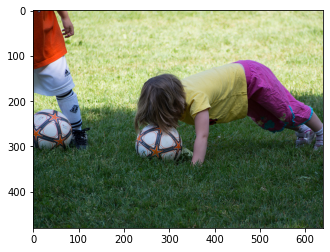

Greedy: những đứa trẻ đang chơi bóng đá trên sân <end> <end> đông quan sát <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>


In [ ]:
z= 0
pic = list(encoding_test.keys())[z]
print(pic)
print(encoding_test[pic])
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [ ]:
pic = '/content/test.jpg'
print(pic)
image = encode(pic, modelInceptionV3)
print(image)
# image = encode(pic, modelInceptionV3).reshape((1,2048))
# x=plt.imread(images+pic)
# plt.imshow(x)
# plt.show()
# print("Greedy:",greedySearch(image))

/content/test.jpg


ValueError: ignored

# Evaluation

In [ ]:
!pip install pycocoevalcap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 104.3 MB 64 kB/s 


In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

In [ ]:
'''
  gts_dict: ground truth
  res_dict: references, predicted
'''

def score(gts_dict, res_dict):
    bleu_score = Bleu(n=4)
    bleu, _ = bleu_score.compute_score(gts=gts_dict, res=res_dict)

    rouge_scorer = Rouge()
    rouge, _ = rouge_scorer.compute_score(gts=gts_dict, res=res_dict)

    cider_scorer = Cider()
    cider, _ = cider_scorer.compute_score(gts=gts_dict, res=res_dict)

    return bleu, rouge, cider



def evaluation_beamSearch(model, descriptions, encoding_test, max_length):
    gts_dict, res_dict = {}, {}
    # step over the whole set
    for key, desc_list in tqdm(descriptions.items()):
        pic = key[len(images):]
        image = encoding_test[pic].reshape((1,2048))
        # generate description
        yhat = beam_search_predictions(pic)
        print(yhat)

        # Trimming <end> from yhat
        splited_yhat = yhat.split()
        y_hat_new = []
        for n in range(max_length):
                word = splited_yhat[n]
                if word != '<end>':
                    y_hat_new.append(word)
                else:
                    break
        yhat = ' '.join(y_hat_new)

        # Trimming <end>, <start> from desc_list
        new_desc_list = []
        for desc in desc_list:
          splited_desc = desc.split()
          desc = ' '.join(splited_desc[1:-1])
          new_desc_list.append(desc)
        desc_list = new_desc_list

        # store actual and predicted
        gts_dict[pic] = desc_list
        res_dict[pic] = [yhat]

    # calculate BLEU score
    b, r, c = score(gts_dict, res_dict)
    print('\n ********** BLEU-4 ********** \n', b)
    print('\n ********** ROUGH ********** \n', r)
    print('\n ********** CIDAr (NOT CIDAr-D) ********** \n', c)

    return gts_dict, res_dict

In [ ]:
'''
  gts_dict: ground truth
  res_dict: references, predicted
'''

def score(gts_dict, res_dict):
    bleu_score = Bleu(n=4)
    bleu, _ = bleu_score.compute_score(gts=gts_dict, res=res_dict)

    rouge_scorer = Rouge()
    rouge, _ = rouge_scorer.compute_score(gts=gts_dict, res=res_dict)

    cider_scorer = Cider()
    cider, _ = cider_scorer.compute_score(gts=gts_dict, res=res_dict)

    return bleu, rouge, cider



def evaluation(model, descriptions, encoding_test, max_length):
    gts_dict, res_dict = {}, {}
    # step over the whole set
    for key, desc_list in tqdm(descriptions.items()):
        pic = key[len(images):]
        image = encoding_test[pic].reshape((1,2048))
        # generate description
        yhat = greedySearch(image)

        # Trimming <end> from yhat
        splited_yhat = yhat.split()
        y_hat_new = []
        for n in range(max_length):
                word = splited_yhat[n]
                if word != '<end>':
                    y_hat_new.append(word)
                else:
                    break
        yhat = ' '.join(y_hat_new)

        # Trimming <end>, <start> from desc_list
        new_desc_list = []
        for desc in desc_list:
          splited_desc = desc.split()
          desc = ' '.join(splited_desc[1:-1])
          new_desc_list.append(desc)
        desc_list = new_desc_list

        # store actual and predicted
        gts_dict[pic] = desc_list
        res_dict[pic] = [yhat]

    # calculate BLEU score
    b, r, c = score(gts_dict, res_dict)
    print('\n ********** BLEU-4 ********** \n', b)
    print('\n ********** ROUGH ********** \n', r)
    print('\n ********** CIDAr (NOT CIDAr-D) ********** \n', c)

    return gts_dict, res_dict

In [ ]:
path = '/content/drive/MyDrive/VinB_IC/Image Captioning/models/N_encoded_test_images.pkl'
test_features = pickle.load(open(path, 'rb'))
print(f'len(train_features): {len(test_features)}')

len(train_features): 231


In [ ]:
# Evaluate the model using evaluation function
actual, predicted = evaluation_beamSearch(model, test_data_dict, test_features, max_length)

  0%|          | 0/231 [00:06<?, ?it/s]

cầu thủ bóng đá trẻ đang đá bóng trên sân cỏ


IndexError: ignored